# Tomographic reconstruction from a rectangular array

In this exercise, you will go from setting up a model of tomographic measurement to reconstructing an attenuation distribution from noisy beam measurements.

The domain in which the attenuation distribution is reconstructed is rectangular, of given width and length. In the particular example that you will work with, this domain is square of length 1 meter, but length and width could have any value. You can assume that the lower-left corner of the reconstructed domain is the origin itself.

You'll work with algebraic reconstruction, so the first thing that you probably want to do is to discretize the domain by representing it as a weighted sum of basis functions. To make things simple, we suggest you choose basis functions with the shape of a disc whose radius $r$ is related to interpixel distance $d$ by $r = \tfrac{d}{\sqrt{2}}$, as illustrated in the figure below.

<img src="grid_round_pixels.png">

We also suggest to model beams as infinitely thin lines, such that the inner product between the k-th pixel and i-th beam, $\langle \phi_k, h_i \rangle$, equals the length of the beam's segment that lies inside that pixel, as illustrated in the following figure:

<img src="beam_and_round_pixel.png">

In the first part of the exercise, you will construct the measurement matrix $A$. In order to help you achieve this, we suggested to implement a few functions that can be used to that end; however, if you prefer to do it differently, you're welcome to take your own route.

Beams are lines defined by their endpoints, given in two matrices: **beam_start** and **beam_end**. Each is of size $n_{\it beams}\times 2$, where $n_{\it beams}$ is the number of beams. The i-th row of **beam_start** contains the $(x,y)$ coordinates of the start of beam $i$, while the i-th row of **beam_end** contains the $(x,y)$ coordinates of the end of beam $i$. Those two matrices should be enough for you to determine the line parametrization, given by $(\theta_i,t_i)$, of every beam. If you forgot, $\theta\in[0,\pi)$ is the angle of the line normal, while $t$ is the signed distance of the line to the origin, along the direction defined by $\theta$.

When you have computed the line parameterization for all the beams, you can compute the inner products $\langle \phi_k, h_i \rangle$ mentioned above by finding the length of the intersection between beams and round pixels. With those, you have everything you need to populate the measurement matrix $A$.

Once you have the measurement matrix $A$, you should be able to reconstruct the pixel values. The vector with measurements, which we denoted by $b$ in the slides, is given in the variable called **measurement**.

The algorithms for algebraic reconstruction were described in the lecture and have been shown in the application session. To simplify your life, we provide a separate file **helpers.py** with some of the functions that have been given to you in the solution to the application session, but you're welcome to use the one that you were given earlier this week.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import scipy.io
from tqdm import tqdm
from scipy import sparse
import os

%matplotlib inline

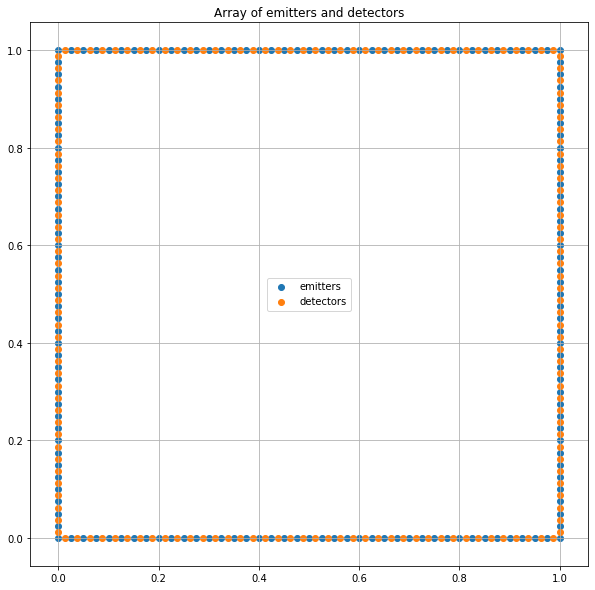

In [2]:
# Load the relevant data from the given .mat file.
data = scipy.io.loadmat('hw2_ex3.mat')

# Read the measurement vector and store it as an array b.
b = data['measurement'].squeeze()

# Beam start and beam end points.
beam_start = data['beam_start']
beam_end = data['beam_end']

# Length and width of the reconstruction domain (in meters, not in pixels).
length = data['length'][0, 0]
width = data['width'][0, 0]

# Arrays containing positions of all emitters and all detectors
# NOTE: not all beams that can be measured are actually measured,
#       that's why the measured beams are defined with beam_start and beam_end
emitter_pos = data['emitter_pos']
detector_pos = data['detector_pos']

# Plot the emitters and detectors.
fig, ax = plt.subplots(1, 1, figsize = (10,10))
plt.scatter(emitter_pos[:,0], emitter_pos[:,1], label='emitters')
plt.scatter(detector_pos[:,0], detector_pos[:,1], label='detectors')
plt.grid()
plt.legend()
plt.title("Array of emitters and detectors")
plt.show()

## Generate the measurement matrix

In [3]:
def compute_beam_line_params(emit_pos, det_pos):
    """
    Compute the line parameters between points in emit_pos and points in det_pos.
    
    NOTE: Make sure that the line normals are between 0 and \pi.
    
    Arguments:
        emit_pos: (n_beams, 2) matrix with emitter positions
        det_pos: (n_beams, 2) matrix with detector positions
    
    Returns: 
        Matrix (n_beams, 2) of (unit-norm) line normals.
        Vector (n_beams,) of line signed-distances from the origin.
    """
    n_beams = emit_pos.shape[0]
    beam_normals = np.zeros((n_beams, 2))
    beam_dist = np.zeros((n_beams, ))
    
    for i in range(n_beams):
        # Choose a line perpendicular to the line (dx, dy)
        # This is parallel to line of interest but going through 0
        dx = det_pos[i,0] - emit_pos[i,0]
        dy = det_pos[i,1] - emit_pos[i,1]
        
        beam_normals[i] =  np.array([-dy, dx])
        
        # Ensure that normal vector have unit norm
        beam_normals[i] = beam_normals[i] / (beam_normals[i] @ beam_normals[i])
        
        # Beam distance is the scalar product of either emitter or detector position
        beam_dist[i] = beam_normals[i] @ emit_pos[i]
        assert np.isclose(beam_normals[i] @ emit_pos[i], beam_normals[i] @ det_pos[i])
    
    return beam_normals, beam_dist

beam_normals, beam_dist = compute_beam_line_params(beam_start, beam_end)

Check that the parametrization is indeed correct. Note that $\text{beam_normals}=(\cos \theta , \sin \theta)^T$ so for the two end points $(x_1, y_1)$ and $(x_2, y_2)$, we must have $\text{beam_dist} = x_i \cos \theta + y_i \sin \theta$

In [4]:
for i in range(beam_normals.shape[0]):
    assert np.isclose(beam_start[i] @ beam_normals[i], beam_dist[i])
    assert np.isclose(beam_end[i] @ beam_normals[i], beam_dist[i])

In [5]:
def beam_pixel_intersection_length(beam_normals, beam_dist, pixel_pos, pixel_r):
    """
    Compute the lenght of the intersection between a thin beam and a round (disc) pixel.
    
    Arguments:
        beam_normals: (2,) vector (\cos(\theta), \sin(\theta)) normal to the beam
        beam_dist: signed distance of the beam line to the origin
        pixel_pos: (2,) vector with (x,y) coordinates of the pixel
        pixel_r: radius of the pixel disc
    
    Returns:
        Length of the beam segment inside the pixel disc.
    """
    # Distance from beam to pixel projected into beam_normal
    length = 2 * (pixel_r - np.absolute(beam_dist - beam_normals @ pixel_pos))
    return length if (length > 0) else 0

In [6]:
# Here you can generate the pixel grid.
# Hint 1: the number of pixels could be equal to the number of measurements
# Hint 2: set pixel sizes according to the number of pixels and the size of the reconstructed domain

# The number of measurements
n_beams = beam_start.shape[0]

# Set N_length and N_width s.t. distance is the same in both axis:
# N_width / width = N_length / length (up to roundings)
N_length = int(np.sqrt(n_beams) * length / width)
N_width = int(N_length * width / length)

pixel_r = width / (N_width * np.sqrt(2))

X, Y = np.meshgrid(np.linspace(0, 1, N_width), 
                   np.linspace(0, 1, N_length), indexing='ij')
pixel_pos = np.stack((X, Y), axis=-1).reshape((N_length * N_width, 2))

Check that previous function is correct by checking some results graphically

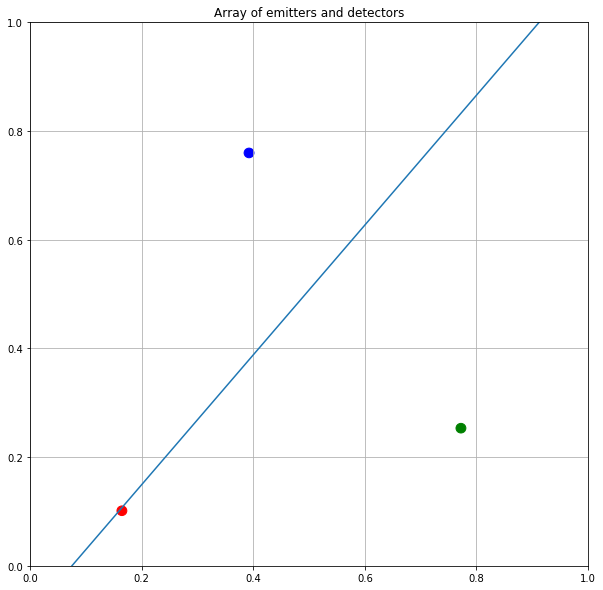

0.012097772966996233
0
0


In [7]:
idx = 123
pixel_idx = [1048, 2540, 4900]

circle1 = plt.Circle((pixel_pos[pixel_idx[0]]), pixel_r, color='r')
circle2 = plt.Circle((pixel_pos[pixel_idx[1]]), pixel_r, color='blue')
circle3 = plt.Circle((pixel_pos[pixel_idx[2]]), pixel_r, color='g')

fig, ax = plt.subplots(1, 1, figsize = (10,10))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.plot([beam_start[idx, 0], beam_end[idx, 0]], [beam_start[idx, 1], beam_end[idx, 1]])
ax.add_artist(circle1)
ax.add_artist(circle2)
ax.add_artist(circle3)

plt.grid()
plt.title("Array of emitters and detectors")
plt.show()

for pixel in pixel_idx:
    print(beam_pixel_intersection_length(beam_normals[idx], beam_dist[idx], pixel_pos[pixel], pixel_r))

In [8]:
def construct_forward_matrix(beam_normals, beam_dist, pixel_pos, pixel_r):
    """
    Constructs the forward matrix from beam line parameters and pixel grid parameters.
    
    Arguments:
        beam_normals: (n_beams, 2) matrix with beam normal vectors (\cos(\phi_i), \sin(\phi_i) in every row
        beam_dist: (n_beams,) vector with beams' signed distances from the origin
        pixel_pos: (n_pixels, 2) matrix with pixel coordinates (x_i,y_i) in every row
        pixel_r: pixel radius
    
    Returns:
        Measurement matrix of size (n_beams, n_pixels) for the given beams
        and the given pixel grid.
    """
    n_beams = beam_normals.shape[0]
    n_pixels = pixel_pos.shape[0]
    
    A = sparse.lil_matrix((n_beams, n_pixels))
    for i in tqdm(range(n_beams)):
        for j in range(n_pixels):
            A[i, j] = beam_pixel_intersection_length(beam_normals[i], beam_dist[i], pixel_pos[j], pixel_r)
    
    return A.tocsr()

Try to avoid recomputing the sampling matrix

In [9]:
fname = 'sampling_mat.npz'

if os.path.isfile(fname):
    A = sparse.load_npz(fname)
else:
    A = construct_forward_matrix(beam_normals, beam_dist, pixel_pos, pixel_r)
    sparse.save_npz(fname, A)

## Reconstruction based on the measurements

Now it's time to try to reconstruct the image from measurements. You should use Kaczmarz algorithm that you can implement yourself (interface provided below), and the version you got in the application session earlier this week can be a good start if you don't like to write things from scratch.

1. Reconstruct the image using the simplest Kaczmarz algorithm with $2 n_{\it beams}$ iterations.
2. Reconstruct the image using a variation of randomized Kaczmarz algorithm with $2 n_{\it beams}$ iterations. There are several ways in which you can randomize the order in which projections are applied:
    * one variant of the randomized Kaczmarz algorithm projects one row at a time, where rows are not swept through sequentially, but rather at every iteration $k$, a row is selected randomly with probability proportional to its squared $l_2$-norm, $\|r_i\|_2^2$
    * another variant of the randomized Kaczmarz algorithm sweeps through the rows sequentially, as in the simple version of the algorithm, but rows are randomly permuted at the start.
3. Try to reconstruct the image using a modified randomized Kaczmarz algorithm with $2 n_{\it beams}$ iterations, where upon computing the projection at every iteration $k$, you apply the box constraint $P_{\cal{C}}(f^{(k)})$, where ${\cal{C}} = [0,1]^{n_{\it pixels}}$ and $n_{\it pixels}$ is the number of pixels.
4. Show the results of the three reconstructions.
5. Do you notice any difference in the quality of the reconstructions? Which algorithm gives the best results?

The images should be two-dimensional. If they appear mirrored or rotated, try to transform them such that you get a good orientation (if your reconstruction is good, you'll have an idea what correction you need).

First, let's plot the reconstruction obtained by Backprojection as a baseline.

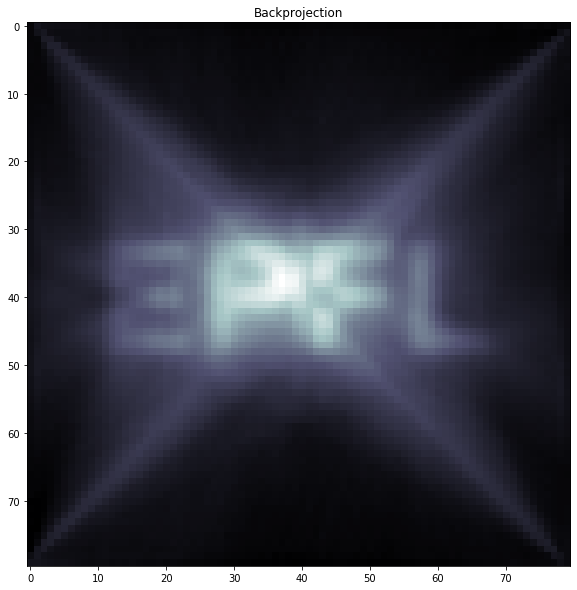

In [10]:
from helpers import backprojection

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

ax.imshow(backprojection(A, b).reshape(N_length, N_width), cmap='bone')
ax.set_title('Backprojection')

plt.show()

In [11]:
def kaczmarz(A, b, n_iter, limits=None, randomize=False, f_0=None):
    """
    Form image via Kaczmarz's algorithm.

    Parameters
    ----------
    A : :py:class:`~scipy.sparse.csr_matrix`
        (n_beams, n_pixels) measurement matrix.
    b : :py:class:`~numpy.ndarray`
        (n_beams,) vector with measurements.
    n_iter : int
        Number of iterations to perform.
    limits : :py:class:`~numpy.ndarray`
        (2,) pixel value constraints. 
        Each pixel of the output image must lie in [`limits[0]`, `limits[1]`].
        If `None`, then the range is not restricted.
    randomize: bool
        Apply a ranomization strategy when applying projections.
    f_0 : :py:class:`~numpy.ndarray`
        (n_pixels,) initial point of the optimization.
        If unspecified, the initial point is set to an all-zero vector.

    Returns
    -------
    f : :py:class:`~numpy.ndarray`
        (n_pixels,) vectorized image
    """
    n_beams, n_pixels = A.shape
    
    f_0 = np.zeros(n_pixels) if (f_0 is None) else f_0
    
    f = f_0
    
    if randomize:
        prob = [sparse.linalg.norm(r) for r in A]
        # Normalize so it represents a probability
        prob = prob / np.sum(prob)
    
    for it in range(n_iter):
        row = np.random.choice(n_beams, p=prob) if randomize else it % n_beams
        
        r_it, b_it = A[row].toarray()[0], b[row]
        l = r_it @ r_it
        
        if ~np.isclose(l, 0):
            # `l` can be very small, in which case it is dangerous to do the rescale. 
            # We'll simply drop these degenerate basis vectors.
            scale = (b_it - r_it @ f) / l
            f += scale * r_it
        
        if limits is not None:
            # Project onto feasible values
            np.clip(f, limits[0], limits[1])

    return f

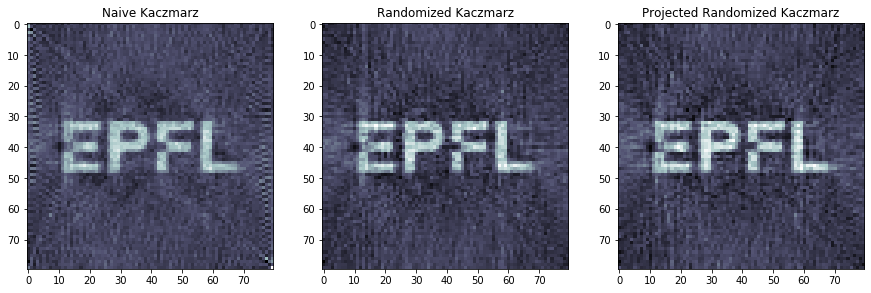

In [12]:
n_iter = 2 * b.shape[0]

fig, ax = plt.subplots(1, 3, figsize = (15, 15))

ax[0].imshow(kaczmarz(A, b, n_iter).reshape(N_length, N_width), cmap='bone')
ax[0].set_title('Naive Kaczmarz')

ax[1].imshow(kaczmarz(A, b, n_iter, randomize=True).reshape(N_length, N_width), cmap='bone')
ax[1].set_title('Randomized Kaczmarz')

im = kaczmarz(A, b, n_iter, limits=[0, 1], randomize=True).reshape(N_length, N_width)
ax[2].imshow(im, cmap='bone')
ax[2].set_title('Projected Randomized Kaczmarz')

plt.show()

For completeness (and for fun) let's use prior information about the reconstructed image:

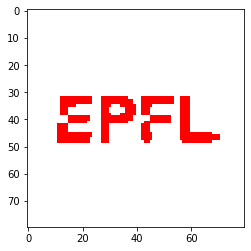

In [13]:
import skimage.filters as filters
from skimage.morphology import opening, closing, square
from matplotlib import colors

im_prior = im > 0.0007
im_prior = opening(im_prior, square(2))
im_prior = closing(im_prior, square(2))

plt.imshow(im_prior, cmap=colors.ListedColormap(['white', 'red']));

## Further instructions

You can supply your solution to this practical exercise by sending me (Mihailo) an email with your Jupyter notebook that contains the solutions, which consists of the code and reconstructed images with your observations written in textual form. You can also put your solution on Github or some other publicly accessible repository and send us a link.

To keep the amount of sent data to the minimum, to you don't need to include the .mat files that you got in the archive.

If you have any question, don't hesitate to ask me during or after a lecture, or just send me an email.